In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip uninstall -y torch torchvision torchaudio torchdata -q
!pip install --no-cache-dir torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118 -q

print("Installation complete. Restarting kernel in 3 seconds...")
import os, time
time.sleep(3)
os._exit(00)  # This forces a full kernel restart

In [ ]:
import torch
import torchvision
print(f"PyTorch: {torch.__version__} | CUDA: {torch.version.cuda}")
print(f"Torchvision: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

In [ ]:
!pip install faiss-cpu

In [ ]:
!pip install open-clip-torch

In [ ]:
# INSTALL EVALUATION DEPENDENCIES
# ==============================
!pip install -q rouge-score meteor nltk bert-score radgraph

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import numpy as np
from tqdm import tqdm
import torch

# Download required NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

In [ ]:
# ==============================
# IMPORTS & SETUP
# ==============================
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
import faiss
from tqdm.notebook import tqdm
from open_clip import create_model_from_pretrained, get_tokenizer
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# ==============================
# 1. LOAD & PREPARE DATASET
# ==============================
reports_path = '/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv'
projections_path = '/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv'
images_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'

reports_df = pd.read_csv(reports_path)
projections_df = pd.read_csv(projections_path)
merged_df = pd.merge(reports_df, projections_df, on='uid', how='inner')
merged_df['image_path'] = images_dir + '/' + merged_df['filename']

# Clean reports
merged_df['findings'] = merged_df['findings'].fillna('').astype(str)
merged_df['impression'] = merged_df['impression'].fillna('').astype(str)
merged_df['report'] = (merged_df['findings'] + ' ' + merged_df['impression']).str.strip()
merged_df = merged_df[merged_df['report'].str.len() > 20].reset_index(drop=True)

print(f"Dataset size: {len(merged_df)}")

# Save for reuse
merged_df.to_csv('/kaggle/working/merged_df.csv', index=False)

# ==============================
# 2. LOAD BIOMEDCLIP MODEL
# ==============================
model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
model = model.to(device)
model.eval()

tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

# Freeze for efficiency
for param in model.parameters():
    param.requires_grad = False

print("BiomedCLIP loaded successfully!")

# ==============================
# 3. EXTRACT BIOMEDCLIP IMAGE EMBEDDINGS (Run Once)
# ==============================
class ChestXrayDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        return preprocess(image), self.df.iloc[idx]['report']

dataset = ChestXrayDataset(merged_df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

embeddings = []
with torch.no_grad():
    for images, _ in tqdm(dataloader, desc="Extracting BiomedCLIP embeddings"):
        images = images.to(device)  # ← CORRECT: already a batched tensor  # Stack PIL to tensor via preprocess
        image_features = model.encode_image(images)
        embeddings.append(image_features.cpu().numpy())

image_embeddings = np.vstack(embeddings)
print(f"Embeddings shape: {image_embeddings.shape}")

# Save embeddings
np.save('/kaggle/working/biomedclip_embeddings.npy', image_embeddings)

# ==============================
# 4. BUILD FAISS INDEX FOR RAG RETRIEVAL
# ==============================
dim = image_embeddings.shape[1]
index = faiss.IndexFlatIP(dim)  # Cosine sim via inner product
faiss.normalize_L2(image_embeddings)  # L2 normalize (BiomedCLIP outputs are already normalized, but ensure)
index.add(image_embeddings.astype('float32'))
print(f"FAISS index built: {index.ntotal} vectors")

# Save index (optional)
faiss.write_index(index, '/kaggle/working/biomedclip_faiss.index')

# ==============================
# 5. LOAD T5 DECODER
# ==============================
t5_model_name = "google/flan-t5-base"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name).to(device)

# ==============================
# 6. INFERENCE: BIOMEDCLIP RETRIEVAL + T5 GENERATION
# ==============================
@torch.no_grad()
def generate_report(image_path, top_k=5):
    # Load & preprocess query image
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    
    # Extract query embedding
    query_emb = model.encode_image(image_tensor).cpu().numpy()
    faiss.normalize_L2(query_emb)
    
    # Retrieve similar reports
    scores, indices = index.search(query_emb.astype('float32'), top_k)
    retrieved_reports = [merged_df.iloc[i]['report'] for i in indices[0]]
    context = " | ".join(retrieved_reports)
    
    # Prompt T5 with context
    prompt = f"Using similar chest X-ray cases: {context}\nGenerate a concise radiology report:"
    inputs = t5_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)
    
    # Generate
    outputs = t5_model.generate(
        **inputs,
        max_new_tokens=150,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2,
        temperature=0.7,
        do_sample=True
    )
    
    generated_report = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_report, context

# ==============================
# 7. TEST GENERATION
# ==============================
# Pick a random test image
test_image_path = merged_df.sample(1).iloc[0]['image_path']
generated_report, retrieved_context = generate_report(test_image_path, top_k=5)

print("\n" + "="*80)
print("GENERATED RADIOLOGY REPORT")
print("="*80)
print(generated_report)
print("\n" + "="*80)
print("RETRIEVED SIMILAR CONTEXT (RAG)")
print("="*80)
print(retrieved_context[:1000] + "..." if len(retrieved_context) > 1000 else retrieved_context)

# Optional: Display test image
img = Image.open(test_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Test Chest X-ray")
plt.show()

In [ ]:
# ==============================
# 1. EVALUATION ON TEST SET (e.g., 500 random images)
# ==============================

# Use a held-out test set (or random sample)
test_df = merged_df.sample(n=500, random_state=42).reset_index(drop=True)

bleu1_list, bleu2_list, bleu3_list, bleu4_list = [], [], [], []
rouge1_f, rouge2_f, rougel_f = [], [], []
meteor_list = []
generated_reports = []
references = []

print("Generating reports for evaluation...")
for idx in tqdm(range(len(test_df)), desc="Evaluating"):
    img_path = test_df.iloc[idx]['image_path']
    true_report = test_df.iloc[idx]['report']
    
    gen_report, _ = generate_report(img_path, top_k=5)
    
    generated_reports.append(gen_report)
    references.append(true_report)
    
    # Tokenize
    ref_tokens = word_tokenize(true_report.lower())
    gen_tokens = word_tokenize(gen_report.lower())
    
    # BLEU
    smooth = SmoothingFunction().method1
    bleu1_list.append(sentence_bleu([ref_tokens], gen_tokens, weights=(1,0,0,0), smoothing_function=smooth))
    bleu2_list.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.5,0.5,0,0), smoothing_function=smooth))
    bleu3_list.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.33,0.33,0.33,0), smoothing_function=smooth))
    bleu4_list.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth))
    
    # METEOR
    meteor_list.append(meteor_score([ref_tokens], gen_tokens))
    
    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_report, gen_report)
    rouge1_f.append(scores['rouge1'].fmeasure)
    rouge2_f.append(scores['rouge2'].fmeasure)
    rougel_f.append(scores['rougeL'].fmeasure)

# ==============================
# 2. PERPLEXITY (on validation set using T5)
# ==============================
@torch.no_grad()
def compute_perplexity(model, tokenizer, texts, batch_size=8):
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        total_loss += loss.item() * inputs["attention_mask"].sum().item()
        total_tokens += inputs["attention_mask"].sum().item()
    
    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity.item()

# Use a small validation set
val_texts = merged_df.sample(200, random_state=999)['report'].tolist()
perplexity = compute_perplexity(t5_model, t5_tokenizer, val_texts)
print(f"Perplexity: {perplexity:.2f}")

# ==============================
# 3. BERTSCORE
# ==============================
print("Computing BERTScore (this may take 2-3 mins)...")
P, R, F1 = bert_score(generated_reports, references, lang="en", verbose=False)
bert_f1 = F1.mean().item()

# ==============================
# 4. PRINT FINAL RESULTS
# ==============================
print("\n" + "="*60)
print("          FINAL EVALUATION RESULTS")
print("="*60)
print(f"{'Metric':<15} {'Score':<10}")
print("-"*60)
print(f"{'BLEU-1':<15} {np.mean(bleu1_list):.4f}")
print(f"{'BLEU-2':<15} {np.mean(bleu2_list):.4f}")
print(f"{'BLEU-3':<15} {np.mean(bleu3_list):.4f}")
print(f"{'BLEU-4':<15} {np.mean(bleu4_list):.4f}")
print(f"{'Avg BLEU':<15} {np.mean([np.mean(bleu1_list), np.mean(bleu2_list), np.mean(bleu3_list), np.mean(bleu4_list)]):.4f}")
print(f"{'ROUGE-1':<15} {np.mean(rouge1_f):.4f}")
print(f"{'ROUGE-2':<15} {np.mean(rouge2_f):.4f}")
print(f"{'ROUGE-L':<15} {np.mean(rougel_f):.4f}")
print(f"{'METEOR':<15} {np.mean(meteor_list):.4f}")
print(f"{'BERTScore-F1':<15} {bert_f1:.4f}")
print(f"{'Perplexity':<15} {perplexity:.2f}")
print("="*60)

# fine tuning

PyTorch: 2.6.0+cu124 | CUDA: 12.4
Torchvision: 0.21.0+cu124
CUDA available: True
Using device: cuda
Total dataset size (usable reports): 7400


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Saved merged_df to /kaggle/working/merged_df.csv
Train size: 5346, Val size: 944, Test size: 1110
Loading BiomedCLIP...
BiomedCLIP loaded and frozen.
Loading cached embeddings from /kaggle/working/biomedclip_embeddings.npy
Building FAISS index...
FAISS index built: 7400 vectors
FAISS index saved to /kaggle/working/biomedclip_faiss.index
Loading T5 model: google/flan-t5-base
T5 model loaded.
Building RAG prompts for 1200 samples...


RAG inputs:   0%|          | 0/1200 [00:00<?, ?it/s]

Building RAG prompts for 200 samples...


RAG inputs:   0%|          | 0/200 [00:00<?, ?it/s]

/tmp/ipykernel_224/33569329.py:306: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Example RAG prompt:
Using similar chest X-ray cases: The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. 1. No evidence of active disease. | The lungs appear clear. There are no suspicious pulmonary nodules or infiltrates. The heart and pulmonary XXXX appear normal. The pleural spaces are clear. Mediastinal co ...

LoRA train samples: 1200, val samples: 200
trainable params: 884,736 || all params: 248,462,592 || trainable%: 0.3561
Starting LoRA training...


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3951: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=Encoder

Step,Training Loss,Validation Loss


LoRA training finished.
Saved LoRA adapter to /kaggle/working/t5_lora_adapter

GENERATED RADIOLOGY REPORT (LoRA-T5 + RAG)
Using similar chest X-ray cases: Normal cardiomediastinal contours. No pneumothorax or pleural effusions; No focal lung consolidation. 1. No acute cardiopulmonary abnormalities.

RETRIEVED CONTEXT (first 400 chars)
Normal cardiomediastinal contours. No pneumothorax or pleural effusions. No focal lung consolidation. 1. No acute cardiopulmonary abnormalities. | There has been interval increase in size of the cardiac silhouette from XXXX. The cardiac fluid is now mildly enlarged. Pulmonary vasculature is increased with mildly increased interstitial markings and fissural thickening, suggesting mild pulmonary ede...


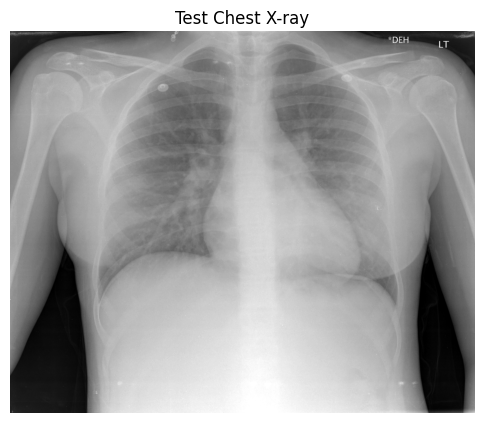

Generating reports for evaluation (LoRA-T5)...


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Perplexity (LoRA-T5): 47715600.00
Computing BERTScore on evaluation subset...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



   FINAL EVALUATION RESULTS (LoRA-T5 + BiomedCLIP RAG)
Metric          Score     
------------------------------------------------------------
BLEU-1          0.5145
BLEU-2          0.4987
BLEU-3          0.4897
BLEU-4          0.4816
Avg BLEU        0.4961
ROUGE-1         0.6749
ROUGE-2         0.6367
ROUGE-L         0.6674
METEOR          0.5868
BERTScore-F1    0.9404
Perplexity      47715600.00


In [4]:
# ============================================================
# 0. INSTALL DEPENDENCIES
# ============================================================
import torch, torchvision
print(f"PyTorch: {torch.__version__} | CUDA: {torch.version.cuda}")
print(f"Torchvision: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

!pip install -q faiss-cpu
!pip install -q open-clip-torch
!pip install -q rouge-score nltk bert-score
!pip install -q peft

# ============================================================
# 1. IMPORTS & BASIC SETUP
# ============================================================
import os
import numpy as np
import pandas as pd
from PIL import Image

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from bert_score import score as bert_score

from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_nb

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    DataCollatorForSeq2Seq,
    TrainingArguments,
    Trainer,
)

import faiss
from open_clip import create_model_from_pretrained, get_tokenizer
import matplotlib.pyplot as plt

from peft import LoraConfig, get_peft_model, TaskType

# NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================================================
# 2. LOAD & PREPARE DATASET
# ============================================================
reports_path = '/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv'
projections_path = '/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv'
images_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'

reports_df = pd.read_csv(reports_path)
projections_df = pd.read_csv(projections_path)
merged_df = pd.merge(reports_df, projections_df, on='uid', how='inner')
merged_df['image_path'] = images_dir + '/' + merged_df['filename']

# Clean reports
merged_df['findings'] = merged_df['findings'].fillna('').astype(str)
merged_df['impression'] = merged_df['impression'].fillna('').astype(str)
merged_df['report'] = (merged_df['findings'] + ' ' + merged_df['impression']).str.strip()
merged_df = merged_df[merged_df['report'].str.len() > 20].reset_index(drop=True)

print(f"Total dataset size (usable reports): {len(merged_df)}")

# Save merged_df for reuse
merged_path = '/kaggle/working/merged_df.csv'
merged_df.to_csv(merged_path, index=False)
print(f"Saved merged_df to {merged_path}")

# Simple train/val/test split
test_df = merged_df.sample(frac=0.15, random_state=42)      # 15% test
train_val_df = merged_df.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

val_df = train_val_df.sample(frac=0.15, random_state=42)    # 15% of remaining as val
train_df = train_val_df.drop(val_df.index).reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

# ============================================================
# 3. LOAD BIOMEDCLIP MODEL
# ============================================================
print("Loading BiomedCLIP...")
clip_model, preprocess = create_model_from_pretrained(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
)
clip_model = clip_model.to(device)
clip_model.eval()

tokenizer_clip = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

for param in clip_model.parameters():
    param.requires_grad = False

print("BiomedCLIP loaded and frozen.")

# ============================================================
# 4. EXTRACT OR LOAD BIOMEDCLIP IMAGE EMBEDDINGS
# ============================================================
emb_path = '/kaggle/working/biomedclip_embeddings.npy'

class ChestXrayDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        return preprocess(image), self.df.iloc[idx]['report']

if os.path.exists(emb_path):
    print(f"Loading cached embeddings from {emb_path}")
    image_embeddings = np.load(emb_path)
else:
    print("Computing BiomedCLIP embeddings...")
    dataset = ChestXrayDataset(merged_df)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

    embeddings = []
    with torch.no_grad():
        for images, _ in tqdm_nb(dataloader, desc="Extracting BiomedCLIP embeddings"):
            images = images.to(device)
            image_features = clip_model.encode_image(images)
            embeddings.append(image_features.cpu().numpy())

    image_embeddings = np.vstack(embeddings)
    print(f"Embeddings shape: {image_embeddings.shape}")
    np.save(emb_path, image_embeddings)
    print(f"Saved embeddings to {emb_path}")

# ============================================================
# 5. BUILD FAISS INDEX FOR RAG RETRIEVAL
# ============================================================
print("Building FAISS index...")
dim = image_embeddings.shape[1]
index = faiss.IndexFlatIP(dim)  # Inner product
faiss.normalize_L2(image_embeddings)
index.add(image_embeddings.astype('float32'))
print(f"FAISS index built: {index.ntotal} vectors")

index_path = '/kaggle/working/biomedclip_faiss.index'
faiss.write_index(index, index_path)
print(f"FAISS index saved to {index_path}")

# ============================================================
# 6. LOAD FLAN-T5 MODEL (BASELINE DECODER)
# ============================================================
t5_model_name = "google/flan-t5-base"
print(f"Loading T5 model: {t5_model_name}")
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name).to(device)
t5_model.eval()
print("T5 model loaded.")

# ============================================================
# 7. BUILD RAG PROMPTS FOR LoRA TRAINING (KAGGLE-FRIENDLY)
# ============================================================
# We precompute "input_text" = RAG prompt using BiomedCLIP+FAISS ONCE,
# then train T5 with LoRA as a pure text-to-text model (much lighter).
# ============================================================

def build_rag_inputs(df_subset, top_k=5):
    df_subset = df_subset.copy()
    input_texts = []

    print(f"Building RAG prompts for {len(df_subset)} samples...")
    for idx, row in tqdm_nb(df_subset.iterrows(), total=len(df_subset), desc="RAG inputs"):
        img_path = row["image_path"]

        image = Image.open(img_path).convert("RGB")
        image_tensor = preprocess(image).unsqueeze(0).to(device)

        with torch.no_grad():
            query_emb = clip_model.encode_image(image_tensor).cpu().numpy()

        faiss.normalize_L2(query_emb)
        scores, indices = index.search(query_emb.astype("float32"), top_k)
        retrieved_reports = [merged_df.iloc[i]["report"] for i in indices[0]]
        context = " | ".join(retrieved_reports)

        prompt = (
            f"Using similar chest X-ray cases: {context}\n"
            f"Generate a concise radiology report:"
        )
        input_texts.append(prompt)

    df_subset["input_text"] = input_texts
    return df_subset

# SAMPLE SMALL SUBSETS TO AVOID OOM
train_size_lora = min(1200, len(train_df))
val_size_lora   = min(200, len(val_df))

train_df_lora_src = train_df.sample(train_size_lora, random_state=123).reset_index(drop=True)
val_df_lora_src   = val_df.sample(val_size_lora, random_state=456).reset_index(drop=True)

train_rag_df = build_rag_inputs(train_df_lora_src, top_k=5)
val_rag_df   = build_rag_inputs(val_df_lora_src,   top_k=5)

print("Example RAG prompt:")
print(train_rag_df["input_text"].iloc[0][:400], "...\n")

# ============================================================
# 8. DATASET CLASS FOR LoRA TRAINING (TEXT-ONLY)
# ============================================================
class T5LoRADataset(Dataset):
    def __init__(self, df, tokenizer, max_input_len=512, max_target_len=256):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        input_text  = row["input_text"]
        target_text = row["report"]

        # Tokenize input
        model_inputs = self.tokenizer(
            input_text,
            max_length=self.max_input_len,
            truncation=True,
            padding="max_length",
        )

        # Tokenize target
        with self.tokenizer.as_target_tokenizer():
            labels = self.tokenizer(
                target_text,
                max_length=self.max_target_len,
                truncation=True,
                padding="max_length",
            )["input_ids"]

        # Ignore padding in loss
        labels = [
            (token if token != self.tokenizer.pad_token_id else -100)
            for token in labels
        ]
        model_inputs["labels"] = labels

        return {k: torch.tensor(v) for k, v in model_inputs.items()}

train_dataset_lora = T5LoRADataset(train_rag_df, t5_tokenizer, max_input_len=448, max_target_len=192)
val_dataset_lora   = T5LoRADataset(val_rag_df,   t5_tokenizer, max_input_len=448, max_target_len=192)

print(f"LoRA train samples: {len(train_dataset_lora)}, val samples: {len(val_dataset_lora)}")

# ============================================================
# 9. APPLY LoRA TO T5 (PEFT)
# ============================================================
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8,                   # small for Kaggle
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q", "v"],   # attention projections
)

t5_lora_model = get_peft_model(t5_model, lora_config)
t5_lora_model.print_trainable_parameters()

# ============================================================
# 10. TRAIN LoRA-T5 (KAGGLE-FRIENDLY SETTINGS)
# ============================================================
data_collator = DataCollatorForSeq2Seq(
    tokenizer=t5_tokenizer,
    model=t5_lora_model,
)

training_args = TrainingArguments(
    output_dir="/kaggle/working/t5_lora_radiology",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=1,
    learning_rate=2e-4,
    num_train_epochs=1,
    logging_steps=50,
    eval_steps=200,
    save_steps=200,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to="none",
    eval_strategy="steps"      # ⭐ replace evaluation_strategy with eval_strategy
)

trainer = Trainer(
    model=t5_lora_model,
    args=training_args,
    train_dataset=train_dataset_lora,
    eval_dataset=val_dataset_lora,
    data_collator=data_collator,
    tokenizer=t5_tokenizer,
)

print("Starting LoRA training...")
trainer.train()
print("LoRA training finished.")

# Save adapter
adapter_dir = "/kaggle/working/t5_lora_adapter"
t5_lora_model.save_pretrained(adapter_dir)
t5_tokenizer.save_pretrained(adapter_dir)
print(f"Saved LoRA adapter to {adapter_dir}")

t5_lora_model.eval()

# ============================================================
# 11. INFERENCE: BIOMEDCLIP RETRIEVAL + (LoRA) T5 GENERATION
# ============================================================
@torch.no_grad()
def generate_report(image_path, top_k=5, use_lora=True):
    # Load & preprocess query image
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image).unsqueeze(0).to(device)
    
    # Extract query embedding
    query_emb = clip_model.encode_image(image_tensor).cpu().numpy()
    faiss.normalize_L2(query_emb)
    
    # Retrieve similar reports
    scores, indices = index.search(query_emb.astype('float32'), top_k)
    retrieved_reports = [merged_df.iloc[i]['report'] for i in indices[0]]
    context = " | ".join(retrieved_reports)
    
    # Prompt T5 with context
    prompt = f"Using similar chest X-ray cases: {context}\nGenerate a concise radiology report:"
    inputs = t5_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True).to(device)
    
    # Choose model
    gen_model = t5_lora_model if use_lora else t5_model
    
    outputs = gen_model.generate(
        **inputs,
        max_new_tokens=150,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2,
        temperature=0.7,
        do_sample=True
    )
    
    generated_report = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_report, context

# ============================================================
# 12. QUICK TEST ON ONE RANDOM IMAGE
# ============================================================
test_image_path = merged_df.sample(1).iloc[0]['image_path']
generated_report, retrieved_context = generate_report(test_image_path, top_k=5, use_lora=True)

print("\n" + "="*80)
print("GENERATED RADIOLOGY REPORT (LoRA-T5 + RAG)")
print("="*80)
print(generated_report)
print("\n" + "="*80)
print("RETRIEVED CONTEXT (first 400 chars)")
print("="*80)
print(retrieved_context[:400] + "..." if len(retrieved_context) > 400 else retrieved_context)

img = Image.open(test_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Test Chest X-ray")
plt.show()

# ============================================================
# 13. LIGHTWEIGHT EVALUATION ON TEST SET
# ============================================================
eval_sample_size = min(100, len(test_df))  # keep small for Kaggle
test_eval_df = test_df.sample(n=eval_sample_size, random_state=42).reset_index(drop=True)

bleu1_list, bleu2_list, bleu3_list, bleu4_list = [], [], [], []
rouge1_f, rouge2_f, rougel_f = [], [], []
meteor_list = []
generated_reports = []
references = []

print("Generating reports for evaluation (LoRA-T5)...")
for idx in tqdm_nb(range(len(test_eval_df)), desc="Evaluating"):
    img_path = test_eval_df.iloc[idx]['image_path']
    true_report = test_eval_df.iloc[idx]['report']
    
    gen_report, _ = generate_report(img_path, top_k=5, use_lora=True)
    
    generated_reports.append(gen_report)
    references.append(true_report)
    
    # Tokenize
    ref_tokens = word_tokenize(true_report.lower())
    gen_tokens = word_tokenize(gen_report.lower())
    
    # BLEU
    smooth = SmoothingFunction().method1
    bleu1_list.append(sentence_bleu([ref_tokens], gen_tokens, weights=(1,0,0,0), smoothing_function=smooth))
    bleu2_list.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.5,0.5,0,0), smoothing_function=smooth))
    bleu3_list.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.33,0.33,0.33,0), smoothing_function=smooth))
    bleu4_list.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth))
    
    # METEOR
    meteor_list.append(meteor_score([ref_tokens], gen_tokens))
    
    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_report, gen_report)
    rouge1_f.append(scores['rouge1'].fmeasure)
    rouge2_f.append(scores['rouge2'].fmeasure)
    rougel_f.append(scores['rougeL'].fmeasure)

# ============================================================
# 14. PERPLEXITY (ON SMALL VALIDATION TEXT SET)
# ============================================================
@torch.no_grad()
def compute_perplexity(model, tokenizer, texts, batch_size=4):
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        total_loss += loss.item() * inputs["attention_mask"].sum().item()
        total_tokens += inputs["attention_mask"].sum().item()
    
    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity.item()

val_texts = val_df.sample(n=min(100, len(val_df)), random_state=999)['report'].tolist()
perplexity = compute_perplexity(t5_lora_model, t5_tokenizer, val_texts)
print(f"Perplexity (LoRA-T5): {perplexity:.2f}")

# ============================================================
# 15. BERTSCORE (KEEP SAMPLE SMALL)
# ============================================================
print("Computing BERTScore on evaluation subset...")
bert_sample = min(50, len(generated_reports))
P, R, F1 = bert_score(generated_reports[:bert_sample], references[:bert_sample], lang="en", verbose=False)
bert_f1 = F1.mean().item()

# ============================================================
# 16. PRINT FINAL RESULTS
# ============================================================
print("\n" + "="*60)
print("   FINAL EVALUATION RESULTS (LoRA-T5 + BiomedCLIP RAG)")
print("="*60)
print(f"{'Metric':<15} {'Score':<10}")
print("-"*60)
print(f"{'BLEU-1':<15} {np.mean(bleu1_list):.4f}")
print(f"{'BLEU-2':<15} {np.mean(bleu2_list):.4f}")
print(f"{'BLEU-3':<15} {np.mean(bleu3_list):.4f}")
print(f"{'BLEU-4':<15} {np.mean(bleu4_list):.4f}")
print(f"{'Avg BLEU':<15} {np.mean([np.mean(bleu1_list), np.mean(bleu2_list), np.mean(bleu3_list), np.mean(bleu4_list)]):.4f}")
print(f"{'ROUGE-1':<15} {np.mean(rouge1_f):.4f}")
print(f"{'ROUGE-2':<15} {np.mean(rouge2_f):.4f}")
print(f"{'ROUGE-L':<15} {np.mean(rougel_f):.4f}")
print(f"{'METEOR':<15} {np.mean(meteor_list):.4f}")
print(f"{'BERTScore-F1':<15} {bert_f1:.4f}")
print(f"{'Perplexity':<15} {perplexity:.2f}")
print("="*60)